In [64]:
import warnings
warnings.filterwarnings("ignore")

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from math import cos, sin
from sklearn.preprocessing import OneHotEncoder

# LR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# K-Means
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

import collections

In [66]:
# Load dataset

initial_dataset = pd.read_csv('House_Price_Prediction.csv')
initial_dataset.shape

(29451, 12)

In [67]:
initial_dataset.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


In [68]:
def cleanDF(data):
    clean_df = data.drop(['POSTED_BY', 'RERA', 'BHK_OR_RK', 'ADDRESS', 'LONGITUDE', 'LATITUDE'], axis=1, errors='ignore')
    return clean_df

In [69]:
def handleCategoricalVariables(data):
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoded_data = encoder.fit_transform(data[['POSTED_BY', 'BHK_OR_RK']])
    column_names = encoder.get_feature_names_out(['POSTED_BY', 'BHK_OR_RK'])
    encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=column_names)
    return encoded_df

In [70]:
def get3DCoordinatesFromLatLong(lat, long):
    # If latitude and longitude are as strings
    # lat = (int)((lat.strip())[1:].split('°')[0])
    # long = (int)((long.strip())[1:].split('°')[0])
    
    r = 10000
    x = r * sin(lat) * cos(long)
    y = r * sin(lat) * sin(long)
    z = r * cos(lat)

    return (x, y, z)

In [71]:
def preprocessDF(data):
    cl_df = cleanDF(data)
    cl_df.rename(columns={'TARGET(PRICE_IN_LACS)': 'PRICE_IN_LACS'}, inplace=True)
    
    x = []
    y = []
    z = []
    for i in range(data.shape[0]):
        xyz = get3DCoordinatesFromLatLong(data.iloc[i,:]['LATITUDE'], data.iloc[i,:]['LONGITUDE'])
        x.append(xyz[0])
        y.append(xyz[1])
        z.append(xyz[2])
    cl_df['X'] = x
    cl_df['Y'] = y
    cl_df['Z'] = z

    cv_df = handleCategoricalVariables(data)

    processed_df = pd.concat([cl_df, cv_df], axis=1)

    return processed_df

In [72]:
processed_dataset = preprocessDF(initial_dataset)
processed_dataset.head()

,UNDER_CONSTRUCTION,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,PRICE_IN_LACS,X,Y,Z,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,BHK_OR_RK_BHK,BHK_OR_RK_RK
0,0,2,1300.236407,1,1,55.0,7436.981766,3175.379663,-5882.879075,0.0,0.0,1.0,1.0,0.0
1,0,2,1275.000000,1,1,51.0,9077.611114,-2727.002340,3187.543679,0.0,1.0,0.0,1.0,0.0
2,0,2,933.159722,1,1,43.0,7704.573157,1655.566148,-6156.188204,0.0,0.0,1.0,1.0,0.0
3,0,2,929.921143,1,1,62.5,-8680.561413,-3346.574721,-3667.191185,0.0,0.0,1.0,1.0,0.0
4,1,2,999.009247,0,1,60.5,-4100.243098,-2811.460662,8676.617745,0.0,1.0,0.0,1.0,0.0


In [73]:
# X = processed_dataset.drop(['PRICE_IN_LACS'], axis=1)
X = processed_dataset
Y = processed_dataset['PRICE_IN_LACS']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)

In [75]:
X_train_xyz = X_train.loc[:,['X', 'Y', 'Z']]
k_optimal = 1
db_min = 1000

inertia = {}
db = {}
for k in range(2,50):
    kmeans = KMeans(n_clusters=k, max_iter=10000, random_state=322)
    kmeans.fit(X_train_xyz)
    labels = kmeans.predict(X_train_xyz)

    inertia[k] = kmeans.inertia_
    db[k] = davies_bouldin_score(X_train_xyz, labels)
    
    if db[k] < db_min:
        db_min = db[k]
        k_optimal = k

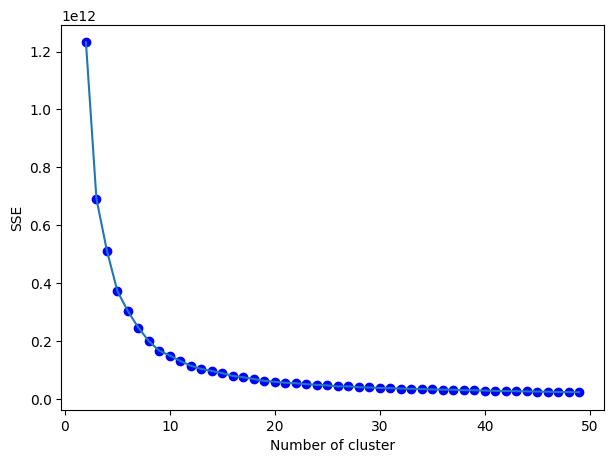

In [76]:
plt.figure(figsize=(7,5))
plt.plot(list(inertia.keys()), list(inertia.values()),'bo')
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

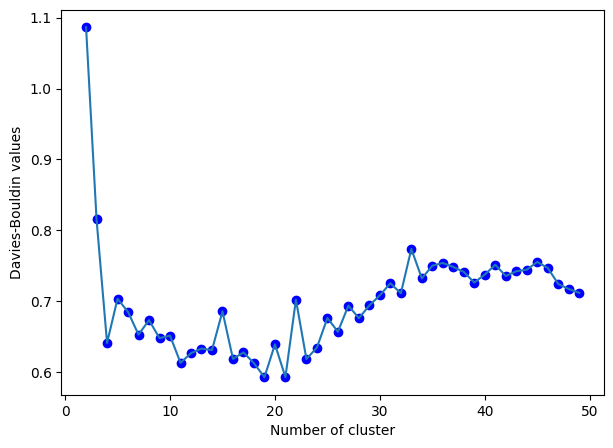

In [77]:
plt.figure(figsize=(7,5))
plt.plot(list(db.keys()), list(db.values()), 'bo')
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

In [78]:
kmeans = KMeans(n_clusters=k, max_iter=100000, random_state=322)
kmeans.fit(X_train_xyz)
labels = kmeans.predict(X_train_xyz)

X_train['LOCALITY_ID'] = labels

In [79]:
localities = []
for locality_id in range(k_optimal):
    localities.append(X_train[X_train['LOCALITY_ID'] == locality_id])

In [80]:
locality_LR = []
locality_LR_r2_score = []

for locality in localities:
    x = locality.drop(['LOCALITY_ID', 'X', 'Y', 'Z', 'PRICE_IN_LACS'], axis=1)
    y = locality['PRICE_IN_LACS']

    linear_reg = LinearRegression()
    linear_reg.fit(x, y)
    locality_LR.append(linear_reg)

    y_pred = linear_reg.predict(x)
    locality_LR_r2_score.append(r2_score(y, y_pred))

In [81]:
X_test_df = X_test.drop(['X', 'Y', 'Z', 'PRICE_IN_LACS'], axis=1)
price_predictions = {}

In [82]:
for locality_id, lr in enumerate(locality_LR):
    price_predictions[f'LOCALITY_{locality_id}_PRICE'] = lr.predict(X_test_df)

In [83]:
price_predictions_df = pd.DataFrame(price_predictions)
price_predictions_df

,LOCALITY_0_PRICE,LOCALITY_1_PRICE,LOCALITY_2_PRICE,LOCALITY_3_PRICE,LOCALITY_4_PRICE,LOCALITY_5_PRICE,LOCALITY_6_PRICE,LOCALITY_7_PRICE,LOCALITY_8_PRICE,LOCALITY_9_PRICE,LOCALITY_10_PRICE,LOCALITY_11_PRICE,LOCALITY_12_PRICE,LOCALITY_13_PRICE,LOCALITY_14_PRICE,LOCALITY_15_PRICE,LOCALITY_16_PRICE,LOCALITY_17_PRICE,LOCALITY_18_PRICE
0,52.422939,109.034327,29.815698,69.635789,45.753527,236.836812,175.345893,74.857817,84.025534,87.502316,82.393377,123.094195,91.376442,66.702209,99.019632,64.561343,82.309856,200.368472,76.980613
1,567.218549,359.369641,686.413661,215.339609,110.430881,805.423950,1073.536787,341.077431,304.929413,309.305991,488.307110,486.422506,338.792304,160.904100,298.799820,219.750000,412.547338,502.843656,111.464021
2,-29.656213,36.083785,-27.330629,30.036713,21.044947,77.612758,82.547869,11.753890,10.416996,49.164538,54.386961,8.516978,8.483144,31.742135,39.769422,21.959991,21.381011,138.787772,43.868734
3,32.489382,25.650299,20.625099,29.315903,32.960590,53.107560,22.875687,13.228112,26.683581,37.227652,33.935070,47.569403,31.781161,38.254693,24.891897,30.645736,22.072970,9.271496,44.703460
4,32.576185,41.189015,21.290266,40.766564,36.527525,91.580211,22.914259,36.013798,46.585407,47.924751,41.443850,77.404136,47.467292,46.300669,42.259345,41.848134,43.569741,53.331601,44.731290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7358,134.132941,115.903527,84.133273,60.538755,55.293042,232.448616,267.979884,41.061290,72.997780,80.348651,78.467283,110.793547,107.561494,67.445243,84.411475,59.522371,51.819601,74.575212,109.974141
7359,351.042229,171.726933,525.731133,28.893790,24.617305,98.949784,639.997752,36.360962,-8.712530,131.279125,362.060300,-27.014329,-8.194514,-1.570054,27.390818,36.465379,100.239727,32.644648,-2.373775
7360,216.241444,194.108143,141.504512,104.009619,81.207703,404.681347,360.790950,111.869693,153.335681,122.303416,109.012626,235.458721,195.758711,105.125886,149.534104,105.911566,120.017105,151.053864,143.095430
7361,134.057417,102.383944,83.554538,50.576017,52.189603,198.975183,267.946324,21.236425,55.682039,71.041556,71.934210,84.835602,93.913652,60.444778,69.300790,49.775636,33.116166,36.240370,109.949928
